# Bike Sharing Linear Regression Model

## Steps
1. Reading , understanding and Visualizing the data
2. Preparing the data for Modelling
    - Train - Test split
    - Rescaling
3. Training the Model 
4. Residual Analysis
5. Predictions and Evaluations on the test set

### Step 1: Reading , understanding and Visualizing the data

In [ ]:
# Import Needed Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import calendar


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
# Setting Plot size globally for better visualization
plt.rcParams["figure.figsize"] = (15,5)

In [ ]:
# Read the dataset
bike_sharing = pd.read_csv('day.csv')
bike_sharing.shape

In [ ]:
bike_sharing.info()

"""No Missing Values and no datatype conversions required"""

In [ ]:
# Drop Insignificant Columns
# instant is unique as it is a record index - it doesn't add any value
# casual and registered are already captured in cnt and the target column is cnt, hence dropping casual and registered
# dropping dteday as the date doesn't add significance because it is already being consumed in other significant forms like month,weekday,holiday and so on
insig_cols = ['instant','dteday','casual','registered']
bike_sharing.drop(insig_cols,axis=1,inplace=True)
bike_sharing.columns

In [ ]:
# Visualizing the data for linearity and multi collinearity
plt.figure()
sns.pairplot(bike_sharing)
plt.show()

"""At this point,temp and atemp may be multi collinear (+vely correlated) and is obviously explainable because temp is the actual temperature and atemp is feeling temperatue. """

In [ ]:
# Visualizing the data: Continuous Independent Variables
plt.figure()
sns.pairplot(data=bike_sharing,x_vars=['temp', 'atemp', 'hum', 'windspeed'],y_vars='cnt')
plt.show()

"""There seems to be linear correlation between temp vs cnt and atemp vs cnt"""

In [ ]:
# Visualizing the data: Categorical Independent Variables
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
sns.boxplot(x='yr',y='cnt',data=bike_sharing)
plt.subplot(2,4,2)
sns.boxplot(x='season',y='cnt',data=bike_sharing)
plt.subplot(2,4,3)
sns.boxplot(x='mnth',y='cnt',data=bike_sharing)
plt.subplot(2,4,4)
sns.boxplot(x='holiday',y='cnt',data=bike_sharing)
plt.subplot(2,4,5)
sns.boxplot(x='weekday',y='cnt',data=bike_sharing)
plt.subplot(2,4,6)
sns.boxplot(x='workingday',y='cnt',data=bike_sharing)
plt.subplot(2,4,7)
sns.boxplot(x='weathersit',y='cnt',data=bike_sharing)
plt.show()


#### Inferences
- year seems to have very good influence of total rental bikes as the entire distribution for 2019 is higher than that of 2018 indicating a pattern
- season seems to have influence on number of people opting for total rental bikes thereby months also have influence
- workingday & weekday doesn't seem to influence total rental bikes 
- Weather situation seems to influence on total rental bikes
- holiday parameter seems to little influence on total rental bikes (by looking at median)

### Step 2:  Preparing the data for Modelling

#### Encoding
 - yes/no variables are already encoded with 1/0. No change needed
 - Certain Nominal Variables are represented as Ordinal variables like season, month, weekday, weathersit. Those has to be converted and dummy encoded

In [ ]:
## Listing Categorical columns and its unique values
column_values = {}
col_list = ['yr','season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
for row in col_list:
    column_values[row] = list(bike_sharing[row].value_counts().index)

print(column_values)

In [ ]:
## Plug in string values from data dict for Nominal Variables which are represented as Ordinal values in the dataset
yr_mappings = {0:'2018',1:'2019'}
season_mappings = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
weathersit_mappings = {1:'Clear',2:'Mist_Cloudy',3:'Light_Snow',4:'Heavy_Rain'}

bike_sharing['yr'] = bike_sharing[['yr']].apply(lambda x : x.map(yr_mappings))
bike_sharing['season'] = bike_sharing[['season']].apply(lambda x : x.map(season_mappings))
bike_sharing['weathersit'] = bike_sharing[['weathersit']].apply(lambda x : x.map(weathersit_mappings))
bike_sharing['mnth'] = bike_sharing['mnth'].apply(lambda x : calendar.month_abbr[x])
bike_sharing['weekday'] = bike_sharing['weekday'].apply(lambda x : calendar.day_abbr[x])
bike_sharing.head()

In [ ]:
## Dummy encoding
var_list_encoding = ['yr','season','mnth','weekday','weathersit']
dummy_encoded_values = pd.get_dummies(data=bike_sharing[var_list_encoding],drop_first=True)

# Add the new encoded cols to original dataframe and drop the source columns
bike_sharing = pd.concat([bike_sharing,dummy_encoded_values],axis=1)
bike_sharing.drop(var_list_encoding,axis=1,inplace=True)

#### Split test train dataset

In [ ]:
df_train, df_test = train_test_split(bike_sharing,train_size=0.7,random_state=100)
df_train.columns

#### Scaling the features using MinMaxScaler

In [ ]:
# Normalize the numerical columns other than categorical dummy cols
num_vars = ['temp','atemp','hum','windspeed','cnt']
scaler = MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])


### Step 3:  Model Building

#### Dividing training set to X and y

In [ ]:
y_train = df_train.pop('cnt')
X_train = df_train

In [ ]:
# Create Linear Regression Model
lm = LinearRegression()
lm.fit(X_train,y_train)

# Running RFE with output number of values as 20
output_var_count = 20
rfe = RFE(lm,n_features_to_select=output_var_count)
rfe = rfe.fit(X_train, y_train)


In [ ]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

In [ ]:
resulting_rfe_cols = X_train.columns[rfe.support_]
resulting_rfe_cols

In [ ]:
X_train.columns[~rfe.support_]

#### Building using stats model to get detailed statistics

In [43]:
# Keeping only the columns from RFE
X_train_rfe = X_train[resulting_rfe_cols]

In [ ]:
# Add Constant
def add_constant(X_train):
    return sm.add_constant(X_train)

In [ ]:
## Build Model and return summary
def build_model(X_train,y_train):
    lm = sm.OLS(y_train,X_train).fit() # Fitting the model
    return lm.summary(),lm # Return summary

In [ ]:
# Compute VIF
def compute_vif(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2) # Rounding to 2 decimal values
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif
    

In [44]:
# Building Model with 20 params from RFE
build_model(add_constant(X_train_rfe),y_train)


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.851
 Model:                            OLS   Adj. R-squared:                  0.845
 Method:                 Least Squares   F-statistic:                     147.4
 Date:                Tue, 08 Feb 2022   Prob (F-statistic):          1.23e-188
 Time:                        23:06:02   Log-Likelihood:                 524.49
 No. Observations:                 510   AIC:                            -1009.
 Df Residuals:                     490   BIC:                            -924.3
 Df Model:                          19                                         
 Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------

In [45]:
# Computing VIF for 15 variables from RFE
compute_vif(X_train_rfe)

,Features,VIF
2,temp,59.17
1,workingday,58.45
3,atemp,53.88
17,weekday_Sun,13.95
16,weekday_Mon,13.36
7,season_spring,5.79
9,season_winter,3.98
0,holiday,3.33
8,season_summer,2.94
12,mnth_Jan,2.37


##### Interpretations:
- RFE chosen 20 variables is able to explain 84% variance in the target variable (Adjusted R square is 84%)
- atemp has high p value and high VIF, Let's start by removing atemp

In [46]:
# Remove atemp which has very high p value and high VIF
cols_to_be_removed = ['atemp']
X_train_rfe_m = X_train_rfe.drop(cols_to_be_removed,axis=1)

In [47]:
build_model(add_constant(X_train_rfe_m),y_train)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.851
 Model:                            OLS   Adj. R-squared:                  0.846
 Method:                 Least Squares   F-statistic:                     155.9
 Date:                Tue, 08 Feb 2022   Prob (F-statistic):          9.80e-190
 Time:                        23:06:15   Log-Likelihood:                 524.48
 No. Observations:                 510   AIC:                            -1011.
 Df Residuals:                     491   BIC:                            -930.5
 Df Model:                          18                                         
 Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------

In [48]:
compute_vif(X_train_rfe_m)

,Features,VIF
1,workingday,58.40
16,weekday_Sun,13.94
15,weekday_Mon,13.35
6,season_spring,5.69
2,temp,4.73
8,season_winter,3.85
0,holiday,3.32
7,season_summer,2.82
11,mnth_Jan,2.37
3,hum,1.94


##### Interpretations:
- Adjusted R square has remained the same indicating that atemp is a redundant variable
- As indicated by EDA, atemp has very high correlation with temp, removing atemp also brought down vif of temp
- holiday has high p value although it has low VIF

As a rule of thumb, remove the variable with high p value, let's remove holiday

In [49]:
# Remove atemp which has very high p value and high VIF
# Remove holiday as it has high p value
cols_to_be_removed = ['atemp','holiday']
X_train_rfe_m = X_train_rfe.drop(cols_to_be_removed,axis=1)

In [50]:
build_model(add_constant(X_train_rfe_m),y_train)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.851
 Model:                            OLS   Adj. R-squared:                  0.846
 Method:                 Least Squares   F-statistic:                     155.9
 Date:                Tue, 08 Feb 2022   Prob (F-statistic):          9.80e-190
 Time:                        23:06:30   Log-Likelihood:                 524.48
 No. Observations:                 510   AIC:                            -1011.
 Df Residuals:                     491   BIC:                            -930.5
 Df Model:                          18                                         
 Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------

In [51]:
compute_vif(X_train_rfe_m)

,Features,VIF
2,hum,34.64
1,temp,22.30
0,workingday,18.92
5,season_spring,6.05
15,weekday_Sun,5.04
3,windspeed,4.99
14,weekday_Mon,4.85
7,season_winter,4.40
6,season_summer,3.11
10,mnth_Jan,2.42


##### Interpretations:
- Adjusted R square has remained the same indicating that removed variables may not be good value add to the fitness of the model
- mnth_Feb has high p value > 0.05

let's remove mnth_Feb

In [52]:
# Remove atemp which has very high p value and high VIF
# Remove holiday as it has high p value
# Remove mnth_Feb as it has high p value 
cols_to_be_removed = ['atemp','holiday','mnth_Feb']
X_train_rfe_m = X_train_rfe.drop(cols_to_be_removed,axis=1)

In [53]:
build_model(add_constant(X_train_rfe_m),y_train)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.850
 Model:                            OLS   Adj. R-squared:                  0.845
 Method:                 Least Squares   F-statistic:                     164.4
 Date:                Tue, 08 Feb 2022   Prob (F-statistic):          2.52e-190
 Time:                        23:06:53   Log-Likelihood:                 523.22
 No. Observations:                 510   AIC:                            -1010.
 Df Residuals:                     492   BIC:                            -934.2
 Df Model:                          17                                         
 Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------

In [54]:
compute_vif(X_train_rfe_m)

,Features,VIF
2,hum,34.19
1,temp,21.56
0,workingday,18.84
5,season_spring,5.06
14,weekday_Sun,5.03
3,windspeed,4.99
13,weekday_Mon,4.83
7,season_winter,4.40
6,season_summer,3.09
16,weathersit_Mist_Cloudy,2.35


##### Interpretations:
- Adjusted R square has remained the same indicating that removed variables may not be good value add to the fitness of the model
- hum has high vif

let's remove hum

In [55]:
# Remove atemp which has very high p value and high VIF
# Remove holiday as it has high p value
# Remove mnth_Feb as it has high p value 
# Remove hum as it has high VIF
cols_to_be_removed = ['atemp','holiday','mnth_Feb','hum']
X_train_rfe_m = X_train_rfe.drop(cols_to_be_removed,axis=1)

In [56]:
build_model(add_constant(X_train_rfe_m),y_train)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.845
 Model:                            OLS   Adj. R-squared:                  0.840
 Method:                 Least Squares   F-statistic:                     168.6
 Date:                Tue, 08 Feb 2022   Prob (F-statistic):          4.83e-188
 Time:                        23:07:23   Log-Likelihood:                 515.05
 No. Observations:                 510   AIC:                            -996.1
 Df Residuals:                     493   BIC:                            -924.1
 Df Model:                          16                                         
 Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------

In [57]:
compute_vif(X_train_rfe_m)

,Features,VIF
0,workingday,17.17
1,temp,13.62
2,windspeed,4.85
13,weekday_Sun,4.70
12,weekday_Mon,4.39
4,season_spring,4.24
6,season_winter,3.71
5,season_summer,2.78
3,yr_2019,2.08
10,mnth_Nov,1.80


##### Interpretations:
- Adjusted R square has approx remained the same indicating that removed variables may not be good value add to the fitness of the model
- weekday_Mon has high p value

let's remove weekday_Mon

In [86]:
# Remove atemp which has very high p value and high VIF
# Remove holiday as it has high p value
# Remove mnth_Feb as it has high p value 
# Remove hum as it has high VIF
# Remove weekday_Mon as it has high p value 
cols_to_be_removed = ['atemp','holiday','mnth_Feb','hum','weekday_Mon']
X_train_rfe_m = X_train_rfe.drop(cols_to_be_removed,axis=1)

In [87]:
summary, final_model = build_model(add_constant(X_train_rfe_m),y_train)
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     178.7
Date:                Tue, 08 Feb 2022   Prob (F-statistic):          1.84e-188
Time:                        23:12:53   Log-Likelihood:                 513.34
No. Observations:                 510   AIC:                            -994.7
Df Residuals:                     494   BIC:                            -926.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1985      0.033      6.031      0.000       0.134       0.263
workingday                 0.0547      0.011      5.009      0.000       0.033       0.076
temp                       0.4354      0.036     12.191      0.000       0.365       0.506
windspeed                 -0.1609      0.025     -6.464      0.000      -0.210      -0.112
yr_2019                    0.2348      0.008     29.173      0.000       0.219       0.251
season_spring             -0.0713      0.021     -3.371      0.001      -0.113      -0.030
season_summer              0.0354      0.015      2.320      0.021       0.005       0.065
season_winter              0.0903      0.018      5.093      0.000       0.055       0.125
mnth_Dec                  -0.0467      0.017     -2.675      0.008      -0.081      -0.012
mnth_Jan                  -0.0526      0.018     -2.905      0.004      -0.088      -0.017
mnth_Jul                  -0.0466      0.018     -2.554      0.011      -0.082      -0.011
mnth_Nov                  -0.0447      0.019     -2.389      0.017      -0.081      -0.008
mnth_Sep                   0.0652      0.017      3.880      0.000       0.032       0.098
weekday_Sun                0.0670      0.014      4.758      0.000       0.039       0.095
weathersit_Light_Snow     -0.2969      0.024    -12.222      0.000      -0.345      -0.249
weathersit_Mist_Cloudy    -0.0818      0.009     -9.526      0.000      -0.099      -0.065
==============================================================================
Omnibus:                       85.035   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.570
Skew:                          -0.805   Prob(JB):                     9.50e-53
Kurtosis:                       5.946   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
compute_vif(X_train_rfe_m)

,Features,VIF
1,temp,6.92
0,workingday,4.74
2,windspeed,4.71
4,season_spring,3.09
6,season_winter,3.03
5,season_summer,2.33
3,yr_2019,2.08
12,weekday_Sun,1.86
10,mnth_Nov,1.79
8,mnth_Jan,1.67


##### Interpretations:
- Adjusted R square has approx remained the same indicating that removed variables may not be good value add to the fitness of the model
- Since all the variables p values are less than 0.05, no feature elimination required based on p value
- Even though temp has slightly higher value of VIF, but removing temp will cause R square to drop by 5%. Since VIF is only slightly higher but temp being able to explain 5% more variance(Adjusted R square) in the data, let's keep temp and declare this as final model

### Step 4:  Residual Analysis

In [65]:
y_train_pred = final_model.predict(add_constant(X_train_rfe_m))
y_train_pred

576    0.753784
426    0.498740
728    0.315280
482    0.595855
111    0.296112
         ...   
578    0.834078
53     0.252189
350    0.265838
79     0.323028
520    0.645137
Length: 510, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


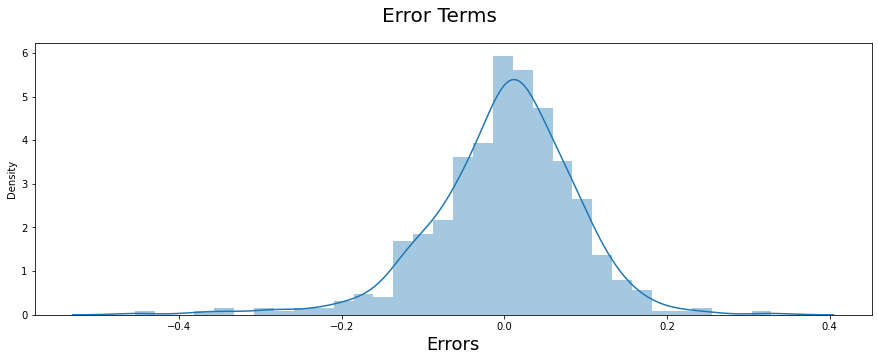

In [66]:
# Plotting the residuals to confirm the Linear Regression Assumptions
res = y_train - y_train_pred
fig = plt.figure()
sns.distplot(res)
fig.suptitle('Error Terms', fontsize = 20)  
plt.xlabel('Errors', fontsize = 18) 
plt.show()

#### Assumptions verified:
- Residuals seems to have zero mean and follow normal distribution 

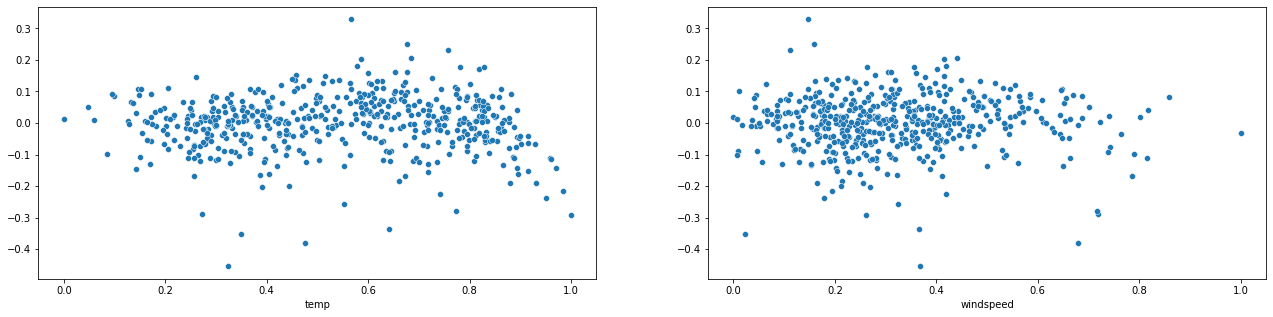

In [101]:
plt.figure(figsize=(22,5))
plt.subplot(1,2,1)
sns.scatterplot(x=X_train_rfe_m['temp'],y=res)
plt.subplot(1,2,2)
sns.scatterplot(x=X_train_rfe_m['windspeed'],y=res)
plt.show()

#### Assumptions verified:
- Residuals doesn't seem to have any pattern and independent
- Residuals seems to have constant variance most of the time except for some outliers

### Step 5:  Predictions and Evaluations using the Final Model

#### Applying the Scaling on test sets


In [67]:
# Normalize the numerical columns other than categorical dummy cols
num_vars = ['temp','atemp','hum','windspeed','cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,yr_2019,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light_Snow,weathersit_Mist_Cloudy
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154,0.481818,0.254545,0.263636,...,0.086364,0.086364,0.145455,0.177273,0.118182,0.100000,0.127273,0.168182,0.027273,0.318182
std,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163,0.500809,0.436599,0.441609,...,0.281541,0.281541,0.353363,0.382770,0.323559,0.300684,0.334038,0.374881,0.163248,0.466833
min,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Splitting the test set into X and y


In [68]:
y_test = df_test.pop('cnt')
X_test = df_test

In [69]:
# Removing columns which were removed during model building process
X_test_final = X_test[X_train_rfe_m.columns] 
X_test_final.columns

Index(['workingday', 'temp', 'windspeed', 'yr_2019', 'season_spring',
       'season_summer', 'season_winter', 'mnth_Dec', 'mnth_Jan', 'mnth_Jul',
       'mnth_Nov', 'mnth_Sep', 'weekday_Sun', 'weathersit_Light_Snow',
       'weathersit_Mist_Cloudy'],
      dtype='object')

In [70]:
y_test_pred = final_model.predict(add_constant(X_test_final))
y_test_pred

184    0.418754
535    0.891123
299    0.430858
221    0.582422
152    0.557954
         ...   
702    0.712038
127    0.477235
640    0.812785
72     0.293521
653    0.751901
Length: 220, dtype: float64

In [89]:
# Rsquare of model from the test set
r_square_test = r2_score(y_test,y_test_pred)
r_square_test

0.8168681962672554

#### Observations
- r_square of test set is just 3% less than that of training set. This implies model generalizes quite well